# Mounting Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFGDp6JDSp6HmWq1uY6Y4-BswW1XYmqqXU6XiL74lIFOgIyRMmMqA0
Mounted at /content/drive


# Importing Important Libraries


In [ ]:
# Implementation of W-Net: A Deep Model for Fully Unsupervised Image Segmentation
# in Pytorch.

import sys
sys.path.append('/content/drive/My Drive/W_NET_Project/Code')


from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
from datetime import datetime
import os, shutil
import copy
from tqdm import notebook
import glob

# Training Code

In [ ]:
from config import Config
import util
from model import WNet
from autoencoder_dataset import AutoencoderDataset
from soft_n_cut_loss import soft_n_cut_loss


def main():
    arr = []
    global INPUT
    print("PyTorch Version: ",torch.__version__)
    if torch.cuda.is_available():
        print("Cuda is available. Using GPU")

    config = Config()

    ###################################
    # Image loading and preprocessing #
    ###################################

    #TODO: Maybe we should crop a large square, then resize that down to our patch size?
    # For now, data augmentation must not introduce any missing pixels TODO: Add data augmentation noise
    train_xform = transforms.Compose([
        transforms.RandomCrop(224),
        transforms.Resize(128),
        transforms.RandomCrop(config.input_size+config.variationalTranslation), # For now, cropping down to 224
        transforms.RandomHorizontalFlip(), # TODO: Add colorjitter, random erasing
        transforms.ToTensor()
    ])
    val_xform = transforms.Compose([
        transforms.CenterCrop(224),
        transforms.Resize(128),
        transforms.CenterCrop(config.input_size),
        transforms.ToTensor()
    ])

    #TODO: Load validation segmentation maps too  (for evaluation purposes)
    train_dataset = AutoencoderDataset("train", train_xform)
    val_dataset   = AutoencoderDataset("val", val_xform)

    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=config.batch_size, num_workers=4, shuffle=True)
    val_dataloader   = torch.utils.data.DataLoader(val_dataset,   batch_size=4, num_workers=4, shuffle=False)

    util.clear_progress_dir()

    ###################################
    #          Model Setup            #
    ###################################


    if(os.path.isfile("/content/drive/My Drive/W_NET_Project/Saved_Model/model.mdl")):
      autoencoder = torch.load("/content/drive/My Drive/W_NET_Project/Saved_Model/model.mdl")
    else:
     autoencoder = WNet()
    if torch.cuda.is_available():
        autoencoder = autoencoder.cuda()
    optimizer = torch.optim.Adam(autoencoder.parameters())
    # if config.debug:
    #     print(autoencoder)
    util.enumerate_params([autoencoder])

    # Use the current time to save the model at end of each epoch
    modelName = str(datetime.now())



    ###################################
    #          Loss Criterion         #
    ###################################

    def reconstruction_loss(x, x_prime):
    	binary_cross_entropy = F.binary_cross_entropy(x_prime, x, reduction='sum')
    	return binary_cross_entropy


    ###################################
    #          Training Loop          #
    ###################################

    autoencoder.train()
    progress_images, progress_expected = next(iter(val_dataloader))

    for epoch in notebook.trange(config.num_epochs):
        running_loss = 0.0
        i=0
        with notebook.tqdm(train_dataloader, leave=False) as Bar:
            for [inputs,outputs] in Bar:

                if config.showdata:
                    print(inputs.shape)
                    print(outputs.shape)
                    print(inputs[0])
                    plt.imshow(inputs[0].permute(1, 2, 0))
                    plt.show()

                if torch.cuda.is_available():
                    inputs  = inputs.cuda()
                    outputs = outputs.cuda()

                    
                optimizer.zero_grad()

                segmentations, reconstructions = autoencoder(inputs)

                l_soft_n_cut     = soft_n_cut_loss(inputs, segmentations)
                l_reconstruction = reconstruction_loss(
                    inputs if config.variationalTranslation == 0 else outputs,
                    reconstructions
                )

                loss = (l_reconstruction + l_soft_n_cut)
                loss.backward(retain_graph=False) # We only need to do retain graph =true if we're backpropping from multiple heads
                optimizer.step()

                
                # print statistics
                running_loss += loss.item()
                Bar.set_postfix(Loss = running_loss/(i+1))                
                i+=1

        epoch_loss = running_loss / len(train_dataloader.dataset) 
        arr.append(epoch_loss)
        print(f"Epoch {epoch} loss: {epoch_loss:.6f}")
        torch.save(autoencoder,'/content/drive/My Drive/W_NET_Project/Saved_Model/model.mdl')

    print("Model Loss:")
    plt.plot(arr)


if __name__ == "__main__":
    main()


PyTorch Version:  1.6.0+cu101


RuntimeError: ignored

# Testing Code

PyTorch Version:  1.6.0+cu101
Cuda is available. Using GPU
Total trainable model parameters: 4871815


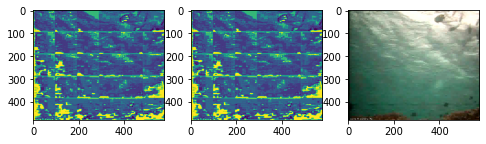

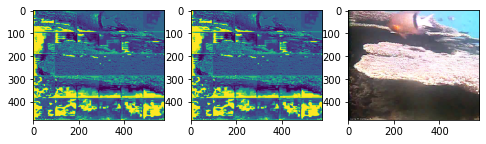

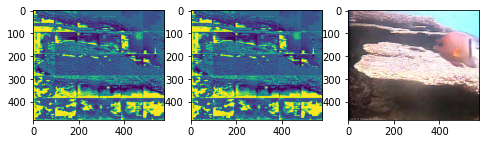

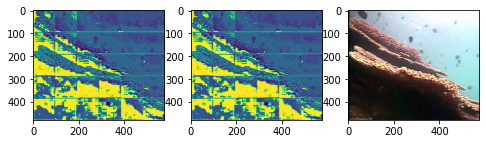

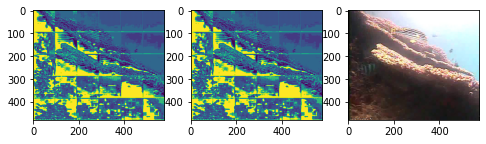

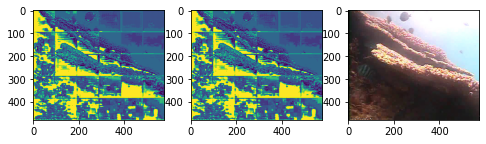

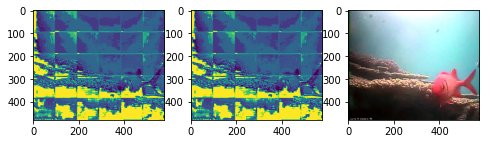

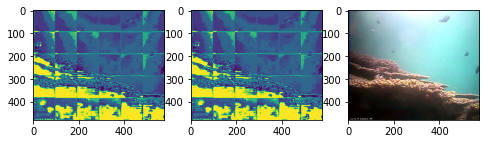

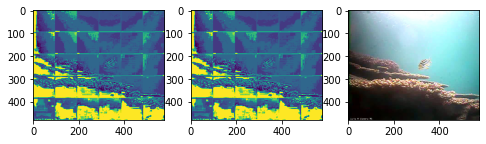

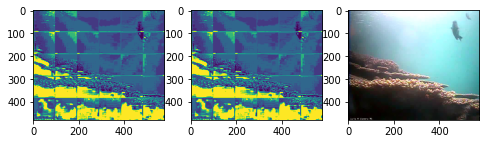

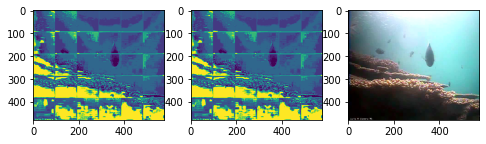

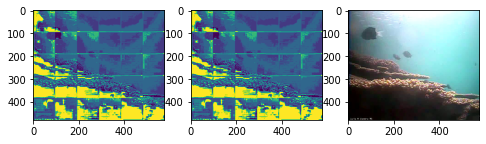

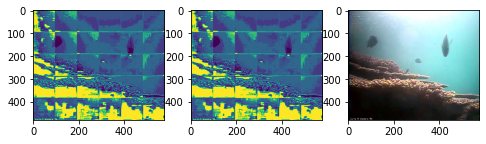

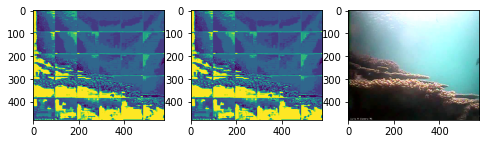

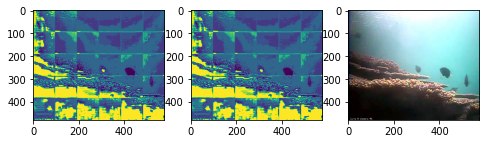

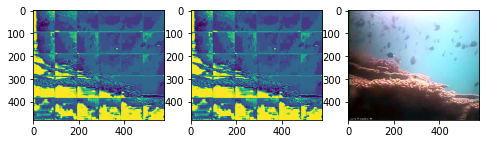

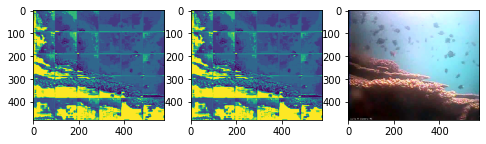

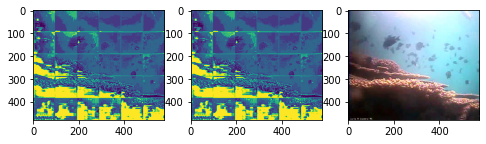

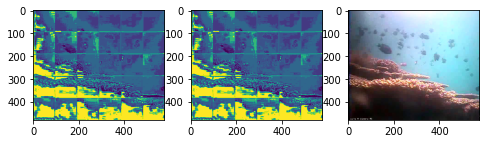

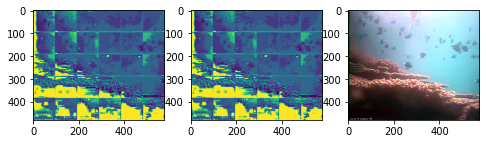

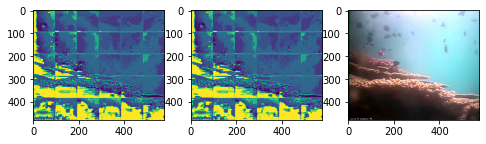

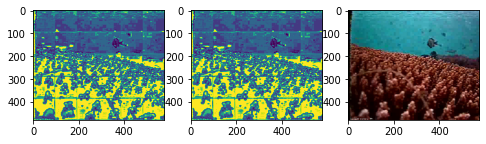

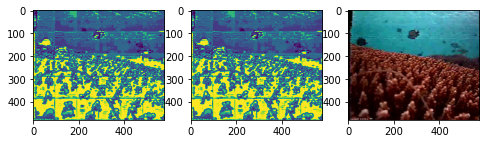

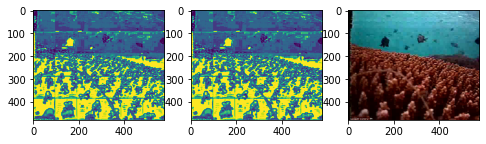

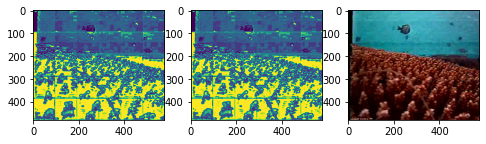

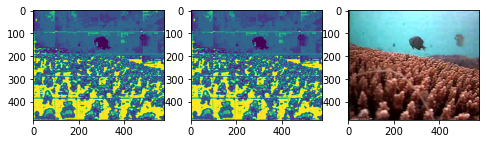

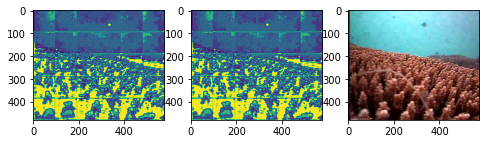

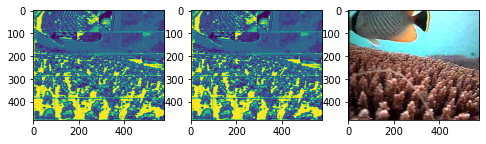

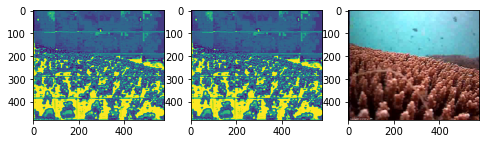

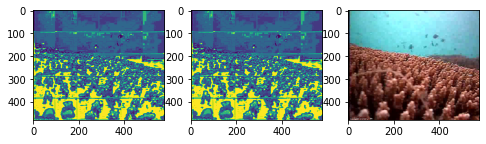

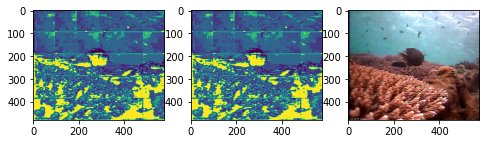

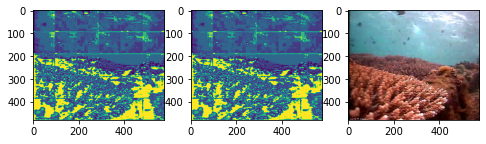

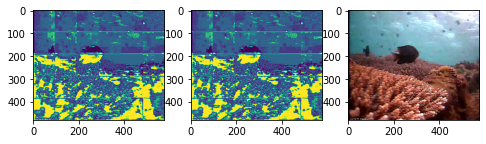

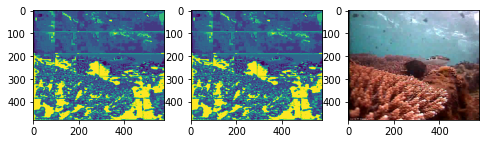

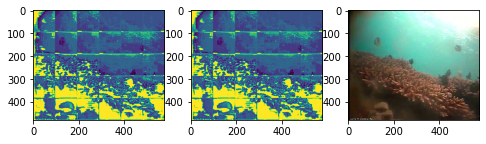

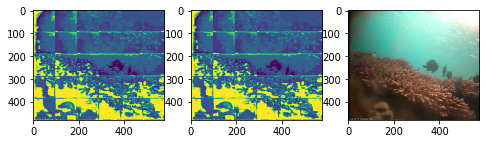

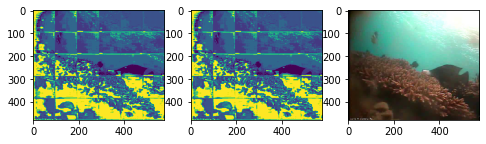

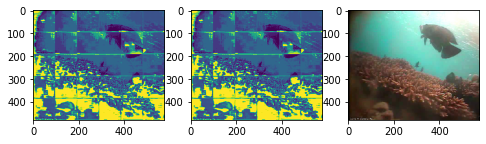

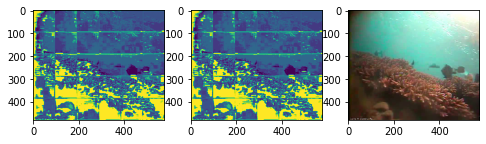

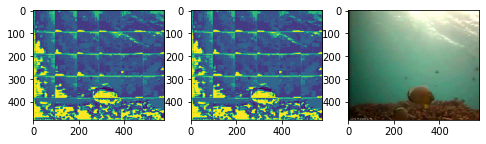

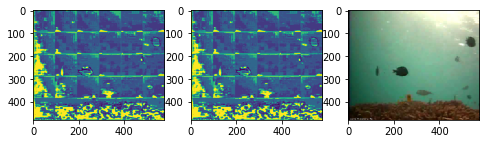

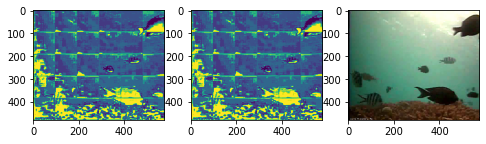

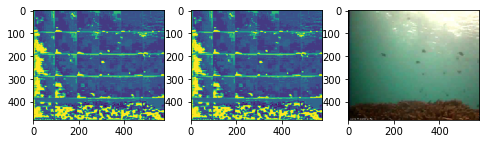

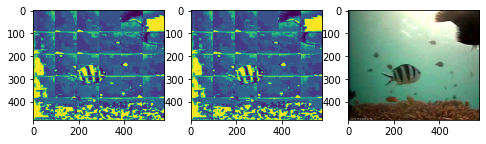

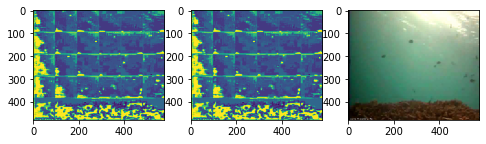

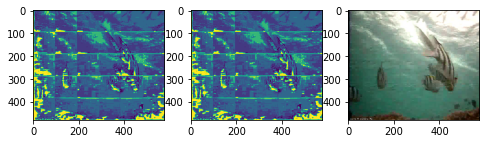

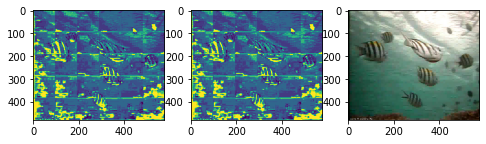

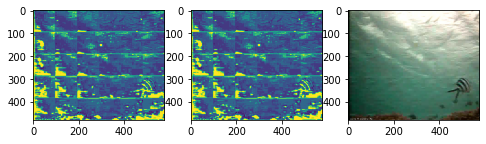

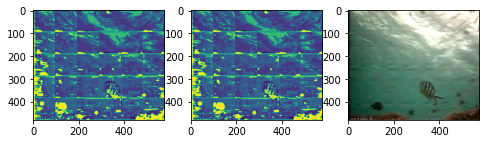

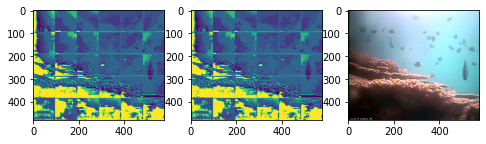

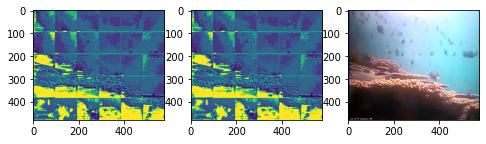

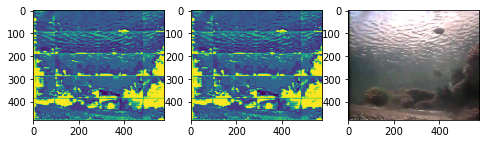

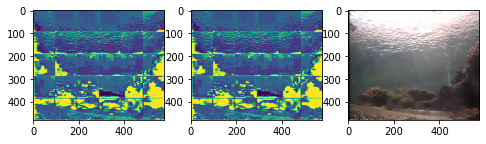

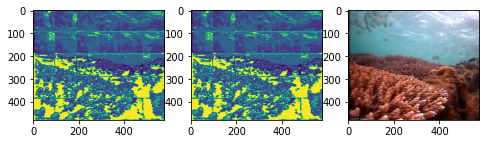

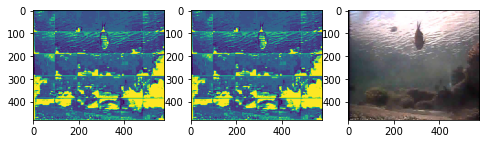

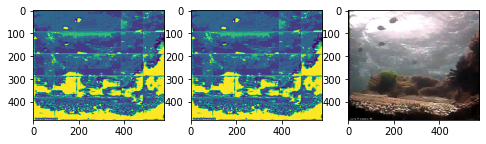

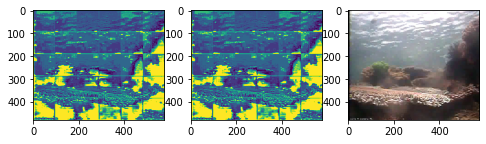

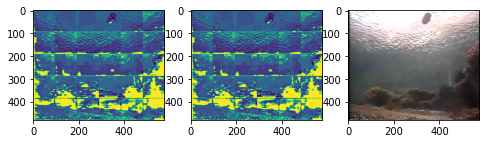

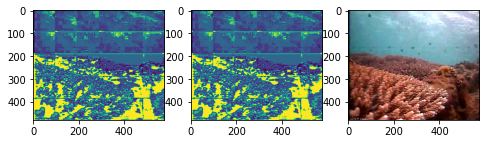

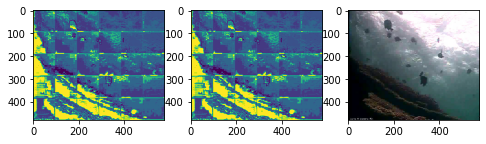

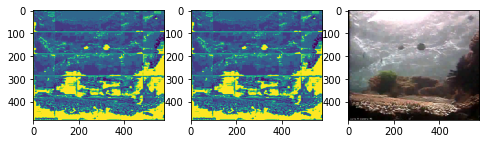

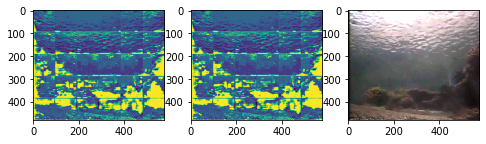

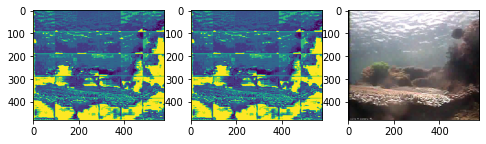

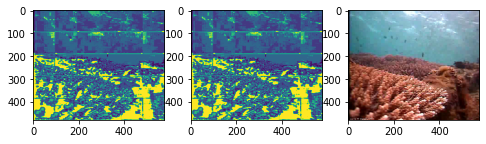

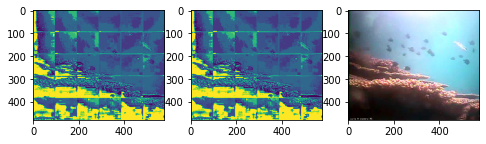

In [ ]:
# Model evaluation script
# As the model is unsupervised, this script tries all possible mappings
# Of segmentation to label and takes the best one.

# Since the model works on patches, we don't need to do any transforms, instead, we just
# need to cut the image into patches and feed all of them through
# Author: Griffin Bishop

from config import Config
import util
from model import WNet
from evaluation_dataset import EvaluationDataset

def main():
    print("PyTorch Version: ",torch.__version__)
    if torch.cuda.is_available():
        print("Cuda is available. Using GPU")

    config = Config()

    ###################################
    # Image loading and preprocessing #
    ###################################

    evaluation_dataset = EvaluationDataset("test")

    evaluation_dataloader = torch.utils.data.DataLoader(evaluation_dataset,
        batch_size=config.test_batch_size, num_workers=4, shuffle=False)

    ###################################
    #          Model Setup            #
    ###################################

    # We will only use .forward_encoder()
    if torch.cuda.is_available():
      autoencoder = torch.load("/content/drive/My Drive/W_NET_Project/Saved_Model/model.mdl")
    else:
        autoencoder = torch.load("/content/drive/My Drive/W_NET_Project/Saved_Model/model.mdl", map_location=torch.device('cpu'))
    util.enumerate_params([autoencoder])

    ###################################
    #          Testing Loop           #
    ###################################

    autoencoder.eval()

    def combine_patches(image, patches):
        w, h = image[0].shape
        segmentation = torch.zeros(w, h)
        x, y = (0,0) # Start of next patch
        for patch in patches:
            if y+size > h:
                y = 0
                x += size
            segmentation[x:x+size,y:y+size] = patch
            y += size
        return segmentation

    # Because this model is unsupervised, our predicted segment labels do not
    # correspond to the actual segment labels.
    # We need to figure out what the best mapping is.
    # To do this, we will just count, for each of our predicted labels,
    # The number of pixels in each class of actual labels, and take the max in that image
    def count_predicted_pixels(predicted, actual):
        pixel_count = torch.zeros(config.k, config.k)
        for k in range(config.k):
            mask = (predicted == k)
            masked_actual = actual[mask]
            for i in range(config.k):
                pixel_count[k][i] += torch.sum(masked_actual == i)
        return pixel_count

    # Converts the predicted segmentation, based on the pixel counts
    def convert_prediction(pixel_count, predicted):
        map = torch.argmax(pixel_count, dim=1)
        for x in range(predicted.shape[0]):
            for y in range(predicted.shape[1]):
                predicted[x,y] = map[predicted[x,y]]
        return predicted

    def compute_iou(predicted, actual):
        intersection = 0
        union = 0
        for k in range(config.k):
            a = (predicted == k).int()
            b = (actual == k).int()
            intersection += torch.sum(torch.mul(a, b))
            union        += torch.sum(((a + b) > 0).int())
        return intersection.float() / union.float()

    def pixel_accuracy(predicted, actual):
        return torch.mean((predicted == actual).float())

    iou_sum = 0
    pixel_accuracy_sum = 0
    n = 0
    # Currently, we produce the most generous prediction looking at a single image
    for i, images in enumerate(evaluation_dataloader, 0):
        size = config.input_size
        # Assuming batch size of 1 right now
        image = images[0]

        # NOTE: We cut the images down to a multiple of the patch size
        cut_w = (image[0].shape[0] // size) * size
        cut_h = (image[0].shape[1] // size) * size
        image = image[:,0:cut_w,0:cut_h]

        # NOTE: problem - the above won't get all patches, only ones that fit. (Resolved by above cutting code)
        patches = image.unfold(0, 3, 3).unfold(1, size, size).unfold(2, size, size)
        patch_batch = patches.reshape(-1, 3, size, size)

        if torch.cuda.is_available():
            patch_batch = patch_batch.cuda()
        seg_batch = autoencoder.forward_encoder(patch_batch)
        seg_batch = torch.argmax(seg_batch, axis=1).float()

        predicted_segmentation = combine_patches(image, seg_batch)
        prediction = predicted_segmentation.int()

        if config.verbose_testing:
            f, axes = plt.subplots(1, 3, figsize=(8,8))
            axes[0].imshow(predicted_segmentation)
            axes[1].imshow(prediction)
            axes[2].imshow(image.permute(1, 2, 0))
            plt.show()

if __name__ == "__main__":
    main()